# Aigerim Gilmanova
## gilmanovab@gmail.com

In [1]:
# necessary libraries
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import gaussian_filter

In [2]:
# necessary torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch. utils.data import DataLoader, TensorDataset

#  Task 3:    Human iris center calculation 

""" The following code uses a CNN model to calculate human iris center. It includes data preprocessing which consists of visualizing images, normalizing them, cropping eye regions and etc. Then, it uses CNN model using PyTorch and combinations of different optimizers, loss and activations functions. """

In [3]:
# accessing data using image_labels.txt file 
images_labels = pd.read_table('gi4e_database/labels/image_labels.txt', header=None,index_col=False, names=range(0,13))

In [4]:
images_labels.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,001_01.png,490.63,338.28,471.22,338.41,452.86,341.93,401.95,342.45,383.33,339.84,362.63,338.41
1,001_02.png,493.49,332.94,479.30,333.33,455.86,340.23,404.69,340.11,391.02,334.50,364.58,335.81
2,001_03.png,495.05,333.86,477.47,332.94,458.07,339.32,407.29,339.71,389.45,333.33,368.88,334.89
3,001_04.png,493.62,334.25,472.66,332.42,456.38,338.80,405.08,340.11,385.03,334.11,367.84,336.46
4,001_05.png,495.83,333.33,470.57,331.64,457.68,338.02,406.77,339.45,382.81,333.33,369.92,334.38


In [5]:
# converting images into gray scale
images = []
for name_im in images_labels[0]:
    img = cv2.imread(f'gi4e_database/images/{name_im}') 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    images.append(gray)  

(600, 800)

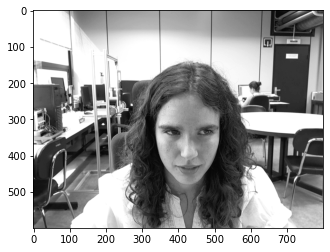

In [6]:
# visualizing image
plt.imshow(images[1], cmap='gray')
images[1].shape

In [7]:
# getting eyes coordinates 
img_num = 1
eyes_x =[images_labels[1][img_num], images_labels[3][img_num], images_labels[5][img_num], images_labels[7][img_num], images_labels[9][img_num], images_labels[11][img_num]]
eyes_y =[images_labels[2][img_num], images_labels[4][img_num], images_labels[6][img_num], images_labels[8][img_num], images_labels[10][img_num], images_labels[12][img_num]]

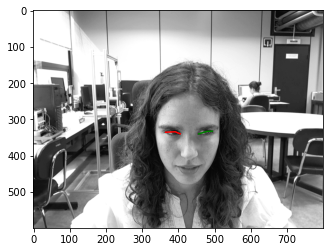

In [8]:
# visualization of eyes regions detection
figure, axis = plt.subplots()
axis.imshow(images[1], cmap='gray')
axis.plot(eyes_x[:3], eyes_y[:3], color='green')
axis.plot(eyes_x[3:], eyes_y[3:], color='red')

In [9]:
# normalizing images
norm_images = []
for i in images:
    i = cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    norm_images.append(i)

images = norm_images

In [10]:
# finding means of left and right eyes on x and y axis to allow cropping eye regions
left_means_x = ((images_labels[1] + images_labels[5])/2)
left_means_y = (images_labels[2] + images_labels[6])/2
right_means_x = (images_labels[7] + images_labels[11])/2
right_means_y = (images_labels[8] + images_labels[12])/2

# converting coordinates from float into int
lx = left_means_x.astype(float).astype(int)
ly = left_means_y.astype(float).astype(int)
rx = right_means_x.astype(float).astype(int)
ry = right_means_y.astype(float).astype(int)

# left coordinates for cropped images
up_lx = lx + 24
low_lx = lx - 24
up_ly = ly + 24
low_ly = ly - 24

# right coordinates for cropped images
up_rx = rx + 24
low_rx = rx - 24
up_ry = ry + 24
low_ry = ry - 24

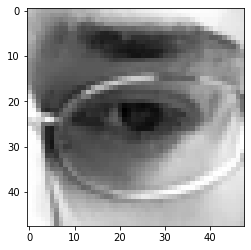

In [11]:
# visualization of croped images, which size is 48x48
test = np.asarray(images)
list_left_eyes = []
list_right_eyes = []

for i in range(len(images)):
    list_left_eyes.append(test[i, low_ly[i]:up_ly[i], low_lx[i]:up_lx[i]])
    list_right_eyes.append(test[i, low_ry[i]:up_ry[i], low_rx[i]:up_rx[i]])

plt.imshow(list_left_eyes[105], cmap="gray")

In [12]:
# making list of X dataset which contains cropped images of left and right eyes
X = list_left_eyes + list_right_eyes
len(X)

2472

In [13]:
# detection of iris center

# coordinates of left iris
left_iris_x = images_labels[3].astype(float).astype(int)
left_iris_y = images_labels[4].astype(float).astype(int)
left_iris_sc_x = left_iris_x - low_lx 
left_iris_sc_y = left_iris_y - low_ly

# coordinates of right iris
right_iris_x = images_labels[9].astype(float).astype(int)
right_iris_y = images_labels[10].astype(float).astype(int)
right_iris_sc_x = right_iris_x - low_rx 
right_iris_sc_y = right_iris_y - low_ry

In [14]:
# creating image of size 48x48 for left and right eyes, where iris is a white spot 
left_pixel_matrices = []
right_pixel_matrices = []

for i in range(len(images)):
    # whole image is a matrix of zeros
    matrix1 = np.zeros((48,48), dtype = np.float32)
    matrix2 = np.zeros((48,48), dtype = np.float32)
    # only iris regions have values of ones
    matrix1[left_iris_sc_y[i]][left_iris_sc_x[i]] = 1.0
    # making gaussian filter to blur the white spot
    matrix1 = gaussian_filter(matrix1, 1)
    matrix2[right_iris_sc_y[i]][right_iris_sc_x[i]] = 1.0
    matrix2 = gaussian_filter(matrix2, 1)
    left_pixel_matrices.append(matrix1)
    right_pixel_matrices.append(matrix2)              

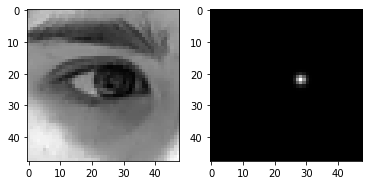

In [15]:
# visualization of eye and its iris
figure, axis = plt.subplots(1,2)
axis[0].imshow(list_right_eyes[109], cmap='gray')
axis[1].imshow(right_pixel_matrices[109], cmap="gray")

In [16]:
# making list of y dataset which contains images with zero and one values
y = left_pixel_matrices + right_pixel_matrices
len(y)

2472

In [17]:
# converting datasets from lists into tensors
X = torch.Tensor(np.asarray(X)[:, np.newaxis])
y = torch.Tensor(np.asarray(y)[:, np.newaxis])

In [18]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train.shape

torch.Size([1977, 1, 48, 48])

In [19]:
# making datasets of tensors
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [20]:
batch_size = 10
test_batch_size = 30

In [21]:
# loading data
train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, test_batch_size)

In [44]:
# lists of optimizers, their parameters, loss and activation functions
opt_list = [optim.SGD, optim.Adam, optim.Adamax, optim.RMSprop]
opt_param = [{'lr': (10e-5),'momentum': (0.5)},  {'lr': (10e-5)}, {'lr': (10e-5)}, {'lr': (10e-5)}]
loss_fun = [F.mse_loss, F.l1_loss]
act_fun = [F.tanh, F.relu, F.sigmoid]

In [45]:
# According to the Fig.3 from the paper, CNN model was created 
class Net(nn.Module):
        
    def __init__(self, fun):
        super(Net, self).__init__()
        self.fun = fun
        
        #Base network 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2) 
        self.conv4 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=4) 
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 1, kernel_size=3, padding=1)   
        
        #Auxiliary network
        self.conv7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.conv9 = nn.Conv2d(64, 1, kernel_size=3, padding=1) 

    def forward(self, x):
        #Base network 
        x = self.fun(self.conv1(x))
        x1 = self.fun(self.conv2(x)) 
        x1 = self.fun(self.conv3(x1))
        
        x2 = self.fun(self.conv4(x1))
        x = torch.cat((x,x2), 1)
        x = self.fun(self.conv5(x))
        x = F.sigmoid(self.conv6(x))
        
        # х1 is the input from the auxiliary network
        
        #Auxiliary network
        x1 = self.fun(self.conv7(x1))
        x1 = self.fun(self.conv8(x1))
        x1 = F.sigmoid(self.conv9(x1))
         
        return x, x1

In [46]:
def train(model, device, train_loader, optimizer, epoch, loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        (output, output2) = model(data)
        # loss function of base network
        loss1 = loss_fn(output[:,:,12:36,12:36], target[:,:,12:36,12:36])
        # loss function of auxiliary network
        loss2 = loss_fn(output2, data)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
        
    return output, output2
            
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            (output, output2) = model(data)
            # loss function of base network
            loss_test1 = loss_fn(output[:,:,12:36,12:36], target[:,:,12:36,12:36], reduction='sum').item()
            # loss function of auxiliary network
            loss_test2 = loss_fn(output2, data, reduction='sum').item()
            loss_test = loss_test1 + loss_test2
            test_loss += loss_test # sum up batch loss

    test_loss /= len(test_loader.dataset) * 48 * 48
    print('\nTest set: Average loss: {:.4f}'.format(test_loss))
    
    return test_loss
    

In [49]:
epochs = 10
log_interval = 80

# combinations of optimizers, loss and activation functions

for losss in loss_fun:
    for num, opt in enumerate(opt_list):
        for funct in act_fun:
            use_cuda = torch.cuda.is_available()
            device = torch.device("cuda" if use_cuda else "cpu")
            model = Net(funct).to(device)    
            optimizer = opt(model.parameters(), **opt_param[num]) 
            for epoch in range(1, epochs + 1):
                train(model, device, train_loader, optimizer, epoch, losss) 
                loss_return = test(model, device, test_loader, losss) 
            
            print(f'Loss Funct: {losss}, Optimizer: {opt}, Activation Funct: {funct}, {loss_return}')


Train Epoch: 1 [0/1977 (0%)]	Loss: 0.281559
Train Epoch: 1 [800/1977 (40%)]	Loss: 0.249987
Train Epoch: 1 [1600/1977 (81%)]	Loss: 0.241547

Test set: Average loss: 0.0942
Train Epoch: 2 [0/1977 (0%)]	Loss: 0.244326
Train Epoch: 2 [800/1977 (40%)]	Loss: 0.213038
Train Epoch: 2 [1600/1977 (81%)]	Loss: 0.207421

Test set: Average loss: 0.0855
Train Epoch: 3 [0/1977 (0%)]	Loss: 0.211396
Train Epoch: 3 [800/1977 (40%)]	Loss: 0.180930
Train Epoch: 3 [1600/1977 (81%)]	Loss: 0.177707

Test set: Average loss: 0.0780
Train Epoch: 4 [0/1977 (0%)]	Loss: 0.182819
Train Epoch: 4 [800/1977 (40%)]	Loss: 0.153731
Train Epoch: 4 [1600/1977 (81%)]	Loss: 0.152617

Test set: Average loss: 0.0718
Train Epoch: 5 [0/1977 (0%)]	Loss: 0.158805
Train Epoch: 5 [800/1977 (40%)]	Loss: 0.131505
Train Epoch: 5 [1600/1977 (81%)]	Loss: 0.132153

Test set: Average loss: 0.0668
Train Epoch: 6 [0/1977 (0%)]	Loss: 0.139287
Train Epoch: 6 [800/1977 (40%)]	Loss: 0.113901
Train Epoch: 6 [1600/1977 (81%)]	Loss: 0.115903

Test 

<!--  -->

According to the results, it can be seen that the best combination is MSE for loss function, Adam for optimizer and tanh for activate function because it has the minimum loss, which is 0.0005254606156077918

In [51]:
# applying best combination of optimizer (Adam), loss (MSE) and activation functions (tanh)
epochs = 40
log_interval = 20
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(F.tanh).to(device)   
optimizer = optim.Adam(model.parameters(), lr=10e-5)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, F.mse_loss) 
    loss_return = test(model, device, test_loader, F.mse_loss)         

Train Epoch: 1 [0/1977 (0%)]	Loss: 0.275897
Train Epoch: 1 [200/1977 (10%)]	Loss: 0.033672
Train Epoch: 1 [400/1977 (20%)]	Loss: 0.038190
Train Epoch: 1 [600/1977 (30%)]	Loss: 0.023358
Train Epoch: 1 [800/1977 (40%)]	Loss: 0.023051
Train Epoch: 1 [1000/1977 (51%)]	Loss: 0.005998
Train Epoch: 1 [1200/1977 (61%)]	Loss: 0.005879
Train Epoch: 1 [1400/1977 (71%)]	Loss: 0.004163
Train Epoch: 1 [1600/1977 (81%)]	Loss: 0.003312
Train Epoch: 1 [1800/1977 (91%)]	Loss: 0.002930

Test set: Average loss: 0.0031
Train Epoch: 2 [0/1977 (0%)]	Loss: 0.003387
Train Epoch: 2 [200/1977 (10%)]	Loss: 0.003180
Train Epoch: 2 [400/1977 (20%)]	Loss: 0.002872
Train Epoch: 2 [600/1977 (30%)]	Loss: 0.002301
Train Epoch: 2 [800/1977 (40%)]	Loss: 0.002435
Train Epoch: 2 [1000/1977 (51%)]	Loss: 0.002581
Train Epoch: 2 [1200/1977 (61%)]	Loss: 0.002745
Train Epoch: 2 [1400/1977 (71%)]	Loss: 0.002217
Train Epoch: 2 [1600/1977 (81%)]	Loss: 0.002116
Train Epoch: 2 [1800/1977 (91%)]	Loss: 0.002060

Test set: Average loss:

In [52]:
 with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        (output, output2) = model(data)
        break

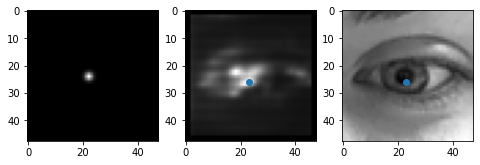

In [87]:
# visualizing iris target, output of the base network and plotting detected iris on the provided data 
imnum = 6
figure, axis = plt.subplots(1,3, figsize=(8, 6))
output[:, :, 0:2, :] = 0
output[:, :, 46:48, :] = 0
output[:, :, :, 0:2] = 0
output[:, :, :, 46:48] = 0
x = output.topk(1, 2)[0].topk(1, 3)[1].squeeze()
y = output.topk(1, 3)[0].topk(1, 2)[1].squeeze()
axis[0].imshow(target[imnum][0], cmap="gray")
axis[1].imshow(output[imnum][0], cmap="gray")
axis[1].scatter(x[imnum], y[imnum])
axis[2].imshow(data.cpu().detach()[imnum][0], cmap="gray")
axis[2].scatter(x[imnum], y[imnum])

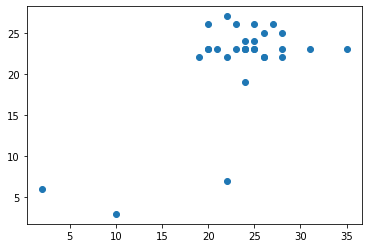

In [54]:
# detecting the largest number by using .topk()
x_top = output.topk(1, 3)[0]
x = x_top.topk(1,2)[1].squeeze()
y_top = output.topk(1, 2)[0]
y = y_top.topk(1,3)[1].squeeze()
y_iris = x
x_iris = y

# overall view or iris
plt.scatter(x_iris, y_iris)

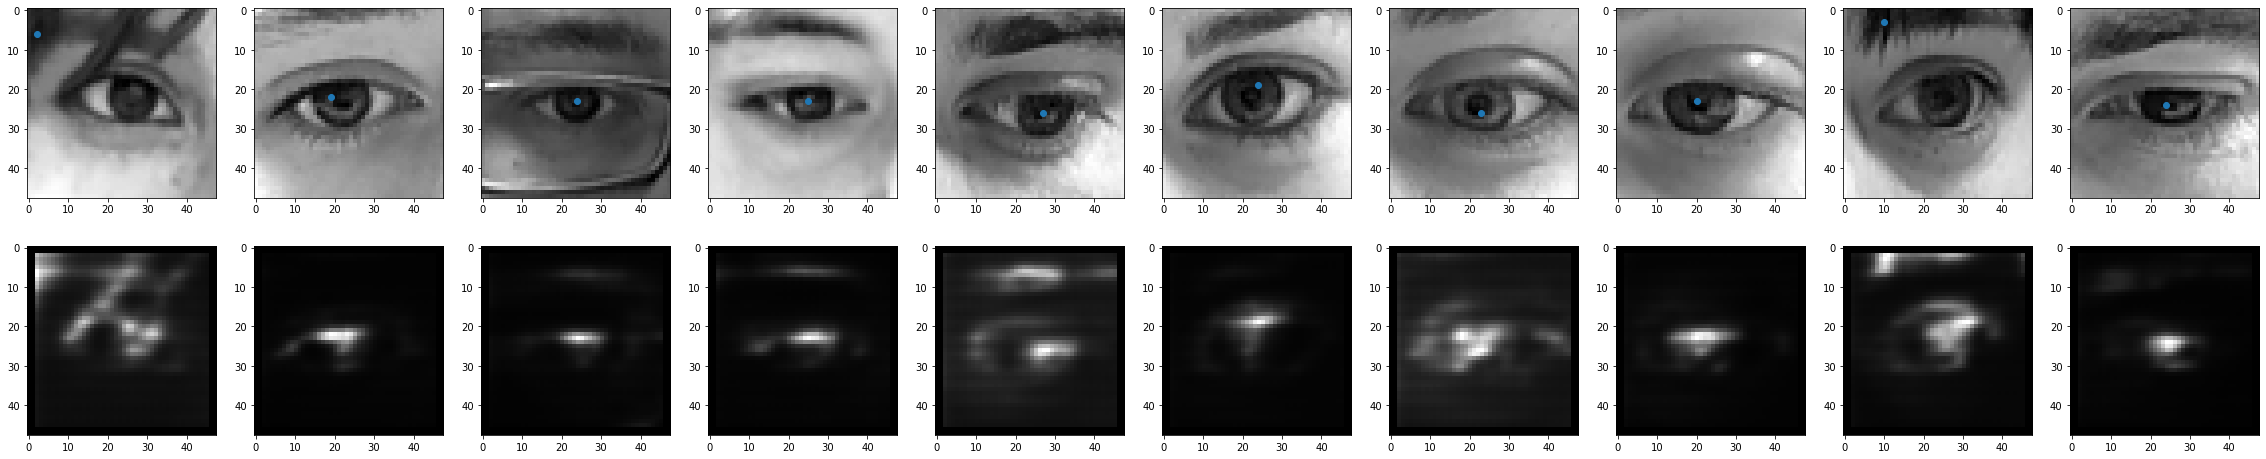

In [75]:
# visualizing data
figure, axis = plt.subplots(2, 10, figsize=(40, 8))
for i in range(10):
    axis[0][i].imshow(data[i][0], cmap="gray")
    axis[0][i].scatter(x_iris[i], y_iris[i])
    axis[1][i].imshow(output[i][0], cmap="gray")

In [81]:
torch.save(model.state_dict(), "final.pt")

# Task 4: Network Intrusions clustering 

In [99]:
# necessary libraries
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import preprocessing, metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph

""" The following code clusters network intrusions by using unsupervised approach. It includes preprocessing data and its visualization by using PCA. Then, it uses 2 machine learning models to cluster networks and detect the outliers. They are: K-Mean and DBSCAN. Also, the code includes Elbow and Silhouette methods as hyperparameters."""

In [100]:
# reading train and test datasets 
train_dataset = pd.read_csv('trainset.csv')
test_dataset = pd.read_csv('testset.csv')

In [101]:
train_dataset.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,1,0,0,0,1,1,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,1,2,0,0,0,1,6,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,2,1,1,3,0,0,0,2,6,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,2,1,1,3,1,1,0,2,1,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,2,1,40,0,0,0,2,39,0


In [102]:
# encoding data to obtain categorical features
label_enc = preprocessing.LabelEncoder()
listt = ['proto', 'service', 'state']
for i in listt:
    # concatinating train and test datasets to have the same labels of encoding
    labels_conc = pd.concat([train_dataset[i], test_dataset[i]])  
    label_enc.fit(labels_conc)
    train_col = label_enc.transform(train_dataset[i])
    test_col = label_enc.transform(test_dataset[i]) 
    # adding encoded labels to the dataset
    train_dataset[i + 'enc'] = train_col
    test_dataset[i + 'enc'] = test_col

In [103]:
train_dataset.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,protoenc,serviceenc,stateenc
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,0,0,0,1,1,0,113,0,4
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,2,0,0,0,1,6,0,113,0,4
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,3,0,0,0,2,6,0,113,0,4
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,3,1,1,0,2,1,0,113,3,4
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,40,0,0,0,2,39,0,113,0,4


In [104]:
# dropping duplicates 
train_dataset = train_dataset.drop(['proto', 'service', 'state'], axis =1)
test_dataset = test_dataset.drop(['proto', 'service', 'state'], axis =1)

In [105]:
train_dataset.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,protoenc,serviceenc,stateenc
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,0,0,0,1,1,0,113,0,4
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,2,0,0,0,1,6,0,113,0,4
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,3,0,0,0,2,6,0,113,0,4
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,3,1,1,0,2,1,0,113,3,4
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,40,0,0,0,2,39,0,113,0,4


In [106]:
# scaling dataset 
scaler = MinMaxScaler()
train_dataset = scaler.fit_transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

<function matplotlib.pyplot.show(close=None, block=None)>

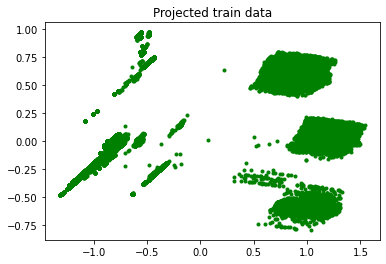

In [107]:
# plotting train data using PCA
pca = PCA(n_components=2)
x_PCA = pca.fit_transform(train_dataset)

plt.title("Projected train data")
plt.plot(x_PCA[:,0], x_PCA[:,1], '.', color="green")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

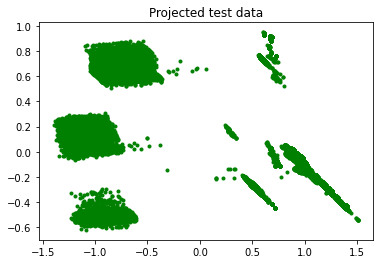

In [108]:
# plotting test data using PCA to reduce dimensions
pca = PCA(n_components=2)
y_PCA = pca.fit_transform(test_dataset)

plt.title("Projected test data")
plt.plot(y_PCA[:,0], y_PCA[:,1], '.', color="green")
plt.show

## K-Mean

K-Mean is a simple method to cluster network. However, it includes outliers into clusters.

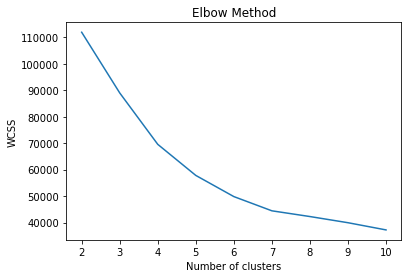

In [25]:
# using elbow method to detect the number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(train_dataset)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The elbow method was used to detect the number of clusters. However, from the obtained graph it is difficult to determine. So, it can be either 6 or 7. Another method to choose k is silhouette method. However, as the train dataset is too large, my laptop could not handle it.

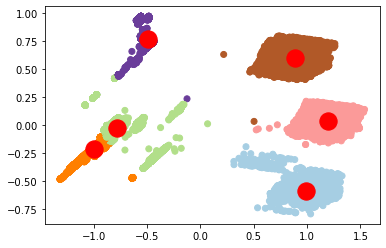

In [93]:
# detecting clusters` centers of train data
# assuming that there are 6 main clusters 
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x_PCA)
plt.scatter(x_PCA[:,0], x_PCA[:,1], c=pred_y, cmap='Paired')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [17]:
# using K-Mean method for train data
KMean = KMeans(n_clusters=6)
KMean.fit(train_dataset)
train_clusters=KMean.predict(train_dataset)

In [18]:
# clusters of train data and their points
pd.DataFrame(train_clusters).value_counts()

2    44388
1    37382
3    33161
0    28469
5    17459
4    14482
dtype: int64

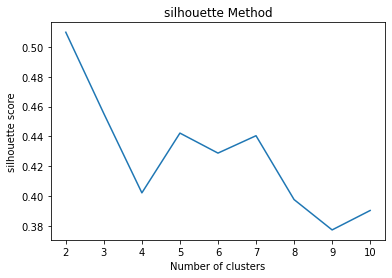

In [27]:
# silhouette method for test data
silhouettes = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(test_dataset)
    y = kmeans.predict(test_dataset)
    score = silhouette_score(test_dataset, y)
    silhouettes.append(score)
plt.plot(range(2, 11), silhouettes)
plt.title('silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

The following method shows that there are 2 clusters which are mostly dense.

In [94]:
KMean = KMeans(n_clusters=6)
KMean.fit(test_dataset)
test_clusters=KMean.predict(test_dataset)

In [95]:
# clusters of test data and their points
pd.DataFrame(test_clusters).value_counts()

4    24329
0    18957
3    12197
1    10782
5    10285
2     5782
dtype: int64

## DBSCAN

The DBSCAN is another method to cluster the network. It is better than K-Mean because DBSCAN works well with clusters of arbitrary shapes. Also, it is robust to outliers and can detect them.

In [88]:
# detecting the most optimal silhouette score for DBSCAN
for i in [0.5, 0.6, 0.7, 0.8]:
    dbscan = DBSCAN(i)
    y_pred = dbscan.fit_predict(test_dataset)
    dbscan_silhouette = silhouette_score(test_dataset, y_pred)
    print('for eps = ' + f'{ i }:' + ' silhouette score is ' + f'{ dbscan_silhouette }')

for eps = 0.5: silhouette score is 0.2848303598905607
for eps = 0.6: silhouette score is 0.38924851061373805
for eps = 0.7: silhouette score is 0.39029503589227355
for eps = 0.8: silhouette score is 0.31773837879101696


In [96]:
# DBSCAN using test dataset because train dataset is too large 
dbscan = DBSCAN(eps=0.7)
y_pred = dbscan.fit_predict(test_dataset)

In [90]:
# clusters and outliers of test data
pd.DataFrame(y_pred).value_counts()

 0     33275
 2     18952
 10    12188
 3     10261
 9      4721
 5      1800
 1       818
 11       61
 14       60
 7        48
 12       38
-1        35
 4        34
 6        24
 13       10
 8         7
dtype: int64

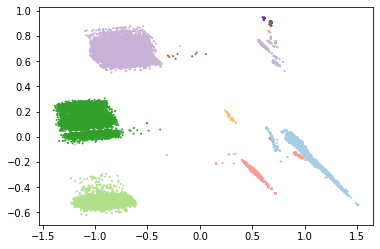

In [102]:
# plotting clusters and outliers for test data
plt.scatter(y_PCA[:, 0],y_PCA[:, 1], c=y_pred, cmap="Paired", s=1)

The graph above shows clusters and outliers for test data. Also, in the main clusters (the most dense areas), outliers can be seen. It happens because of dimensions reduction. 

In the following task, two methods were used to cluster the network. First method is K-Mean, the second is DBSCAN. According to the results, it can be seen that DBSCAN is more suitable for this task because it detects outliers (anomalies). 

# Task 5: Design Patterns Detection 

In [89]:
# necessary libraries
from sklearn.svm import SVC
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

""" The following code estimates java projects according to their design patterns, which are Creational, Structural and Behavioral. It includes preprocessing data, including data and feature extraction. Then, it uses 3 machine learning models to classify the following projects. They are: Random Forest, Decision Tree and SVM classifiers. After applying these models, the code checks its metrics. """

In [90]:
# accessing train dataset
folder_list = os.listdir('Dp_trainset')
folder_list

['Abstract_factory',
 'Adapter',
 'Bridge',
 'Builder',
 'Chain_of_responsibility',
 'Command',
 'Composite',
 'Decorator',
 'Facade',
 'Factory',
 'Flyweight',
 'Interpreter',
 'Iterator',
 'Mediator',
 'Memento',
 'Observer',
 'Prototype',
 'Proxy',
 'Singleton',
 'State',
 'Strategy',
 'Template',
 'Visitor']

In [92]:
# creating three lists of three main patterns type 
Creational = ['Abstract_factory', 'Builder', 'Factory', 'Prototype', 'Singleton']
Structural = ['Adapter','Bridge', 'Composite', 'Decorator', 'Facade', 'Flyweight', 'Proxy']
Behavioral = ['Chain_of_responsibility', 'Command', 'Interpreter', 'Iterator','Mediator','Memento','Observer', 'State','Strategy', 'Template','Visitor']

In [91]:
# creating train dataset (metrics_data) of class features for each project
metrics_data = []
projects = []
for each_folder in glob.glob('Dp_trainset\*'):
    for each_project in glob.glob(f"{each_folder}\*"):      
        for each_metrics in glob.glob(f"{each_project}\ckmetrics\class*"):
            data = pd.read_csv(each_metrics)
            # dropping 'file', 'class' and 'type' columns from class files
            data = data.drop(["file","class", "type"], axis=1)
            # using .sum() method to sum all rows from class files
            metrics_data.append(data.sum())
            projects.append(os.path.basename(each_folder))
            
metrics_data = pd.DataFrame(metrics_data)
print(len(projects), metrics_data.shape)        

369 (369, 44)


In [93]:
metrics_data.head()

,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,44.0,23.0,22.0,39.0,6.0,-2.4,-2.0,23.0,1.0,21.0,...,23.0,8.0,21.0,0.0,0.0,0.0,0.0,119.0,3088.0,0.0
1,23.0,20.0,13.0,12.0,3.0,0.0,0.0,14.0,2.0,14.0,...,4.0,0.0,3.0,6.0,0.0,0.0,0.0,61.0,1035.0,0.0
2,33.0,20.0,14.0,18.0,9.0,0.0,0.0,20.0,2.0,14.0,...,8.0,0.0,8.0,0.0,0.0,0.0,0.0,114.0,14.0,0.0
3,16.0,16.0,9.0,4.0,1.0,3.0,4.0,16.0,3.0,15.0,...,14.0,2.0,14.0,0.0,0.0,0.0,0.0,59.0,7.0,0.0
4,30.0,35.0,13.0,19.0,22.0,0.0,0.0,29.0,2.0,20.0,...,6.0,5.0,6.0,3.0,0.0,0.0,0.0,107.0,1.0,0.0


In [109]:
# creating function for getting target values for train data
def targetget(x):
    for i in x:
        if i in Creational:
            return 0
        elif i in Structural:
            return 1
        else :
            return 2

In [110]:
# mapping each target values with each project
target = pd.DataFrame(projects).apply(targetget, axis=1)

In [111]:
# adding target to the dataset (metrics_data)
metrics_data['target'] = target
metrics_data.head()

,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,...,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,target
0,44.0,23.0,22.0,39.0,6.0,-2.4,-2.0,23.0,1.0,21.0,...,8.0,21.0,0.0,0.0,0.0,0.0,119.0,3088.0,0.0,0
1,23.0,20.0,13.0,12.0,3.0,0.0,0.0,14.0,2.0,14.0,...,0.0,3.0,6.0,0.0,0.0,0.0,61.0,1035.0,0.0,0
2,33.0,20.0,14.0,18.0,9.0,0.0,0.0,20.0,2.0,14.0,...,0.0,8.0,0.0,0.0,0.0,0.0,114.0,14.0,0.0,0
3,16.0,16.0,9.0,4.0,1.0,3.0,4.0,16.0,3.0,15.0,...,2.0,14.0,0.0,0.0,0.0,0.0,59.0,7.0,0.0,0
4,30.0,35.0,13.0,19.0,22.0,0.0,0.0,29.0,2.0,20.0,...,5.0,6.0,3.0,0.0,0.0,0.0,107.0,1.0,0.0,0


In [112]:
# splitting into X_train and y_train 
X_train = metrics_data.drop('target', axis=1)
y_train = metrics_data['target']

In [113]:
# scaling train input data
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [114]:
X_train.head()

,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,0.013452,0.004528,0.024221,0.006391,0.000594,0.060530,0.048742,0.006605,0.002809,0.007943,...,0.008321,0.012270,0.007818,0.000000,0.0,0.0,0.0,0.005311,0.063302,0.0
1,0.007031,0.003937,0.013841,0.001967,0.000297,0.079645,0.060927,0.004021,0.005618,0.005295,...,0.001447,0.000000,0.001117,0.019417,0.0,0.0,0.0,0.002655,0.021217,0.0
2,0.010089,0.003937,0.014994,0.002950,0.000891,0.079645,0.060927,0.005744,0.005618,0.005295,...,0.002894,0.000000,0.002978,0.000000,0.0,0.0,0.0,0.005082,0.000287,0.0
3,0.004891,0.003150,0.009227,0.000656,0.000099,0.103538,0.085298,0.004595,0.008427,0.005673,...,0.005065,0.003067,0.005212,0.000000,0.0,0.0,0.0,0.002564,0.000143,0.0
4,0.009172,0.006890,0.013841,0.003114,0.002179,0.079645,0.060927,0.008329,0.005618,0.007564,...,0.002171,0.007669,0.002234,0.009709,0.0,0.0,0.0,0.004761,0.000020,0.0


<Figure size 2160x720 with 0 Axes>

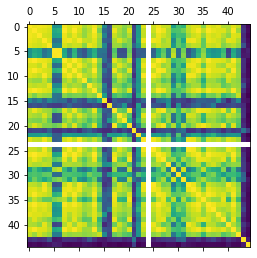

In [115]:
# plotting correlation matrix to see the pattern dependence of classes features
dfCorr = metrics_data.corr()
plt.figure(figsize=(30,10))
plt.matshow(dfCorr)
plt.show()

The brighter region, the higher dependency

In [116]:
# repeating all steps before for test data
# creating test dataset (metrics_test_data) of class features for each project
metrics_test_data = []
test_projects = []
for each_test_folder in glob.glob('Dp_testset\*'):
    for each_test_project in glob.glob(f"{each_test_folder}\*"):      
        for each_test_metrics in glob.glob(f"{each_test_project}\ckmetrics\class*"):
            data1 = pd.read_csv(each_test_metrics)
            data1 = data1.drop(["file","class", "type"], axis=1)
            metrics_test_data.append(data1.sum())
            test_projects.append(os.path.basename(each_test_folder))
            

metrics_test_data = pd.DataFrame(metrics_test_data)
print(len(test_projects), metrics_test_data.shape)     

114 (114, 44)


In [117]:
# creating function for getting target values for test data
def testtargetget(x):
    for i in x:
        if i in Creational:
            return 0
        elif i in Structural:
            return 1
        else :
            return 2

In [118]:
# mapping each target values with each project 
test_target = pd.DataFrame(test_projects).apply(testtargetget, axis=1)

In [119]:
# adding target to the dataset (metrics_data)
metrics_test_data['target'] = test_target
metrics_test_data.head()

,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,...,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,target
0,9.0,9.0,9.0,4.0,1.0,0.0,0.0,6.0,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,24.0,1029.0,0.0,0
1,47.0,28.0,34.0,17.0,7.0,0.0,0.0,28.0,2.0,28.0,...,0.0,4.0,0.0,0.0,0.0,0.0,236.0,6165.0,0.0,0
2,50.0,35.0,41.0,28.0,7.0,-2.0,-2.0,27.0,7.0,20.0,...,8.0,21.0,6.0,0.0,0.0,0.0,160.0,7191.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0
4,21.0,9.0,5.0,4.0,4.0,0.0,0.0,9.0,1.0,7.0,...,0.0,3.0,0.0,0.0,0.0,0.0,68.0,5.0,0.0,0


In [120]:
# splitting into X_test and y_test 
x_test = metrics_test_data.drop('target', axis=1)
y_test = metrics_test_data['target']

In [121]:
# scaling test input data
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [122]:
x_test.head()

,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,0.002751,0.001772,0.009227,0.000656,0.000099,0.079645,0.060927,0.001723,0.000000,0.001513,...,0.000000,0.00000,0.000000,0.003236,0.0,0.0,0.0,0.000961,0.021094,0.0
1,0.014369,0.005512,0.038062,0.002786,0.000693,0.079645,0.060927,0.008041,0.005618,0.010590,...,0.001447,0.00000,0.001489,0.000000,0.0,0.0,0.0,0.010667,0.126379,0.0
2,0.015286,0.006890,0.046136,0.004589,0.000693,0.063716,0.048742,0.007754,0.019663,0.007564,...,0.007598,0.01227,0.007818,0.019417,0.0,0.0,0.0,0.007188,0.147411,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.071680,0.054835,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000137,0.000020,0.0
4,0.006420,0.001772,0.004614,0.000656,0.000396,0.079645,0.060927,0.002585,0.002809,0.002648,...,0.001085,0.00000,0.001117,0.000000,0.0,0.0,0.0,0.002976,0.000102,0.0


In [123]:
# evaluating best parameters by using grid search for Random Forest (ensemble model)
param_grid = {'n_estimators': range(50,100),
              'max_features': ['auto', 'log2'], 
              'min_impurity_decrease': np.arange(0.0, 0.05, 0.01)}

rfc = RandomForestClassifier(random_state = 1)

grid_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 7, scoring='accuracy')


grid_rfc.fit(X_train, y_train)
means = grid_rfc.cv_results_['mean_test_score']
stds = grid_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))
print()
print("Best parameters set found on development set:")
print()
print(grid_rfc.best_params_)

0.699 (+/-0.117) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 50}
0.705 (+/-0.117) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 51}
0.707 (+/-0.106) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 52}
0.707 (+/-0.111) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 53}
0.707 (+/-0.118) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 54}
0.707 (+/-0.118) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 55}
0.707 (+/-0.114) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 56}
0.710 (+/-0.115) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 57}
0.707 (+/-0.115) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 58}
0.710 (+/-0.115) for {'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 59}
0.707 (+/-0.114) for {'max_features': 'a

In [124]:
# Random Forest Classifier
rfc1=RandomForestClassifier(**{'max_features': 'auto', 'min_impurity_decrease': 0.0, 'n_estimators': 84})

rfc1.fit(X_train,y_train)
y_train_pred = rfc1.predict(X_train)
y_test_pred = rfc1.predict(x_test)

# checking train data
print('Accuracy of train data is ' + f'{accuracy_score(y_train, y_train_pred)}')

# checking test data
print('Accuracy of test data is ' + f'{accuracy_score(y_test, y_test_pred)}')

Accuracy of train data is 0.997289972899729
Accuracy of test data is 0.47368421052631576


In [53]:
# evaluating best parameters by using grid search for Decision Tree Clasifier

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']}


dtc = DecisionTreeClassifier(random_state = 1)

grid_dtc = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                          cv = 7, scoring='accuracy')


grid_dtc.fit(X_train, y_train)
means = grid_dtc.cv_results_['mean_test_score']
stds = grid_dtc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_dtc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))
print()
print("Best parameters set found on development set:")
print()
print(grid_dtc.best_params_)

0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2'}
0.667 (+/-0.015) for {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 8, 'max_features'

In [127]:
# Decision Tree Classifier
dtc1 = DecisionTreeClassifier(**{'ccp_alpha': 0.1, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'})

dtc1.fit(X_train,y_train)
y_train_pred = dtc1.predict(X_train)
y_test_pred = dtc1.predict(x_test)

# checking train data
print('Accuracy of train data is ' + f'{accuracy_score(y_train, y_train_pred)}')

# checking train data
print('Accuracy of test data is ' + f'{accuracy_score(y_test, y_test_pred)}')

Accuracy of train data is 0.6666666666666666
Accuracy of test data is 0.3333333333333333


In [128]:
# evaluating best parameters by using grid search for SVM Classifier
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

svc = SVC()

grid_svc = GridSearchCV(estimator = svc, param_grid = param_grid, 
                          cv = 7, scoring = 'accuracy')


grid_svc.fit(X_train, y_train)
means = grid_svc.cv_results_['mean_test_score']
stds = grid_svc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_svc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))
print()
print("Best parameters set found on development set:")
print()
print(grid_svc.best_params_)

0.667 (+/-0.015) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.659 (+/-0.031) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.667 (+/-0.015) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.648 (+/-0.065) for {'C': 100, 'gamma': 1, 'kernel': 'rbf

In [129]:
# SVM Classifier
svc1 = SVC(**{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'})

svc1.fit(X_train,y_train)
y_train_pred = svc1.predict(X_train)
y_test_pred = svc1.predict(x_test)

# checking train data
print('Accuracy of train data is ' + f'{accuracy_score(y_train, y_train_pred)}')

# checking test data
print('Accuracy of test data is ' + f'{accuracy_score(y_test, y_test_pred)}')

Accuracy of train data is 0.6666666666666666
Accuracy of test data is 0.3333333333333333


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: Co

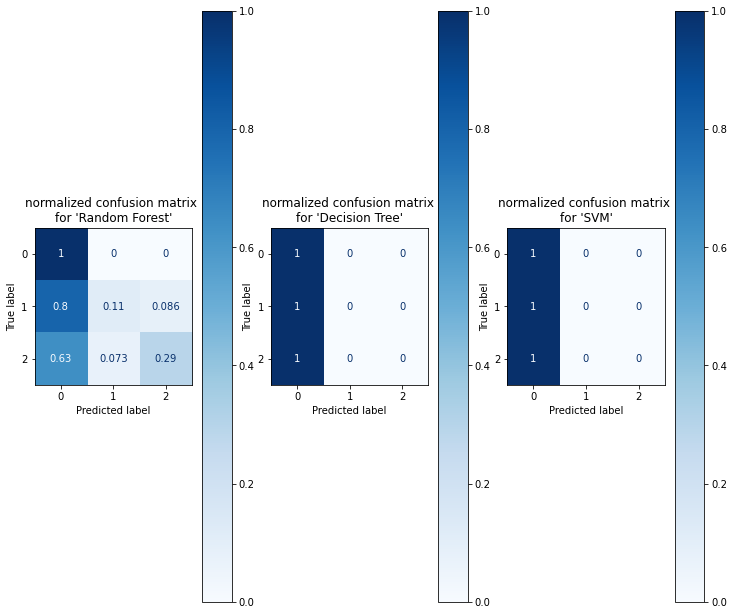

In [130]:
# plotting normalized confusion matrix to evaluate the performance of each classification model
list_models = ['Random Forest', 'Decision Tree', 'SVM']
models = [rfc1, dtc1, svc1]
fig, ax = plt.subplots(1,3,figsize=(12, 12))

for i, model in enumerate(models):
    disp = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, ax=ax[i], normalize='true')
    ax[i].title.set_text(f"normalized confusion matrix \nfor '{list_models[i]}'")

## Results

|Model | | Accuracy |
| --- | --- | --- |
| Random Forest |  | 0.997289972899729|
| Decision Tree| | 0.6666666666666666|
| SVM | | 0.6666666666666666 |

                                                  Table 1. Accuracy for train data

|Model | | Accuracy |
| --- | --- | --- |
| Random Forest |  | 0.47368421052631576 |
| Decision Tree| | 0.3333333333333333|
| SVM | | 0.3333333333333333 |

                                                  Table 1. Accuracy for test data

## Conclusion

According to the results and confusion matrices, it can be seen that Random Forest Classifier shows better result than Decision Tree and SVM, which is 0.474 for test data. Random Forest performed better because the provided dataset is large and has a lot of outliers, while this ensemble model is robust to noise. Decision Tree and SVM are sensitive to outliers. However, accuracies of all models are not high. Thus, to improve models results, feature selection can be done. For instance, instead of using only class files, method and variable files can be analyzed, as well. 